In [1]:
import numpy as np
import pandas as pd
import math
from datetime import datetime
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import mean_squared_error

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

## Data Preparation

In [2]:
def parse(x):
    return datetime.strptime(x, '%Y %m %d %H')

In [3]:
" Loading data"

df = pd.read_csv('raw.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
df.drop('No', axis=1, inplace=True)
df.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
df.index.name = 'date'
df['pollution'].fillna(0, inplace=True)
df = df[24:]

In [4]:
df.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


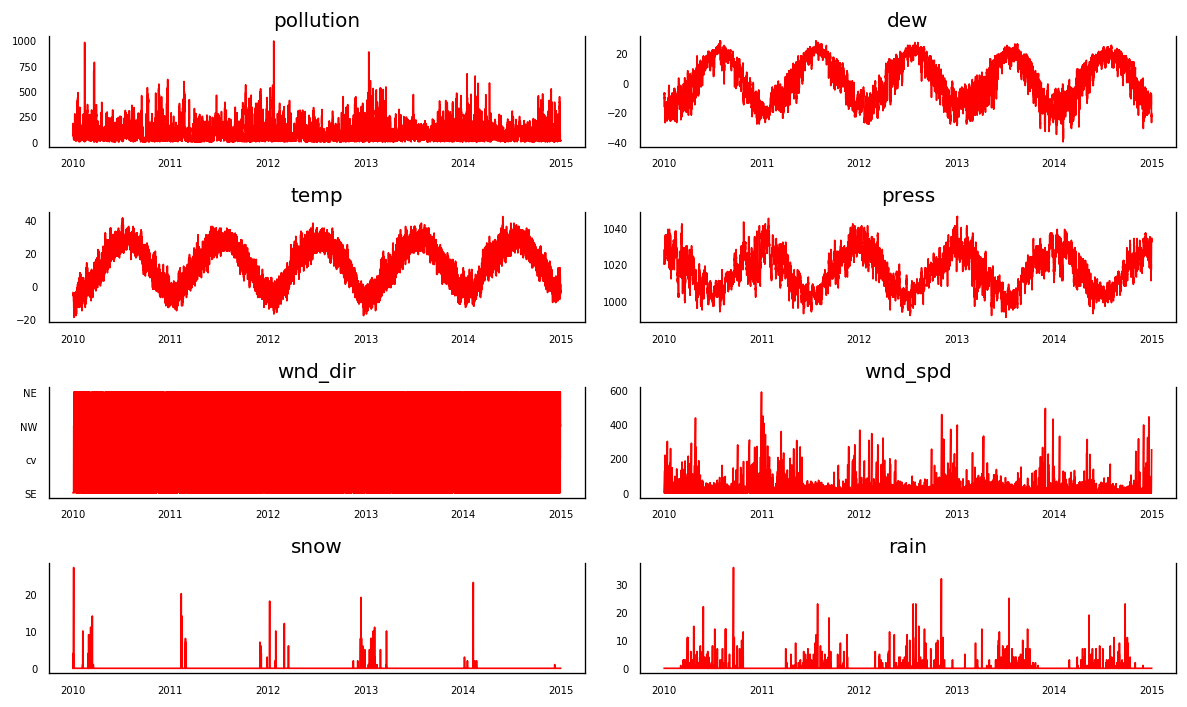

In [6]:
fig, axes = plt.subplots(nrows=4, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [9]:
encoder = LabelEncoder()
df['wnd_dir'] = encoder.fit_transform(df['wnd_dir'])

#### Testing Causation using Granger’s Causality Test

In [14]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df, variables = df.columns)   

C:\Users\Youcef\Anaconda3\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 10, but rank is 1
  'rank is %d' % (J, J_), ValueWarning)
C:\Users\Youcef\Anaconda3\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 11, but rank is 1
  'rank is %d' % (J, J_), ValueWarning)


,pollution_x,dew_x,temp_x,press_x,wnd_dir_x,wnd_spd_x,snow_x,rain_x
pollution_y,1.0000,0.0000,0.0,0.0000,0.0000,0.0000,0.1349,0.0000
dew_y,0.0000,1.0000,0.0,0.0000,0.0000,0.0000,0.0056,0.4654
temp_y,0.0000,0.0000,1.0,0.0000,0.0000,0.0000,0.2351,0.0032
press_y,0.0000,0.0000,0.0,1.0000,0.0000,0.0000,0.0092,0.0028
wnd_dir_y,0.0000,0.0000,0.0,0.0000,1.0000,0.0000,0.1646,0.0000
wnd_spd_y,0.0000,0.0000,0.0,0.0000,0.0000,1.0000,0.0866,0.4817
snow_y,0.4986,0.0269,0.0,0.0002,0.3981,0.0339,1.0000,0.8229
rain_y,0.0472,0.0000,0.0,0.0000,0.0803,0.4764,0.6450,1.0000
